# Covermap Comparison

**Author:** Adam Yang (ayang115@umd.edu)

**Description:** Compares datasets against test sets

**Crop Maps Used:** Harvest Togo & Kenya, Copernicus Land Cover, ESA CCI Land Cover Africa, GLAD Global Cropland Extent

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import geemap
from pathlib import Path
from sklearn.metrics import classification_report 

In [4]:
import ee

ee.Authenticate()

ee.Initialize()


Successfully saved authorization token.


## **Section 0** - Setup

**Functions**

In [5]:
# Remaps classes to crop/noncrop 
def map_values(val, value_for_crop):
    if val == value_for_crop:
        return 1
    else:
        return 0

In [6]:
# Function used in map function to extract from feature collection
def raster_extraction(image, resolution, f_collection):
    feature = image.sampleRegions(
        collection = f_collection,
        scale = resolution
    )
    return feature

In [7]:
# Convert sklearn classification report dict to 
def report_to_row(dataset, report, df):
    new_report = pd.DataFrame(data = {
        "dataset": dataset, 
        "accuracy": report["accuracy"], 
        "crop_f1": report["1"]["f1-score"], 
        "crop_support": report["1"]["support"], 
        "noncrop_support": report["0"]["support"], 
        "crop_precision": report["1"]["precision"], 
        "crop_recall": report["1"]["recall"], 
        "noncrop_precision": report["0"]["precision"], 
        "noncrop_recall": report["0"]["recall"]
        }, index=[0])
    
    return pd.concat([df, new_report])

In [8]:
# Creates ee.Feature from longitude and latitude coordinates from a dataframe
def create_point(row):
    geom = ee.Geometry.Point(row["lon"], row["lat"])
    prop = dict(row)

    return ee.Feature(geom, prop)

**Generate Test Data**

In [9]:
TEST_COUNTRIES = ["Kenya", "Togo", "Tanzania_CEO_2019"]
DATA_PATH = "../data/datasets/"
TEST_CODE = {"Kenya": "KEN", "Togo": "TGO", "Tanzania_CEO_2019": "TZA"}

In [10]:
datasets_path = Path(DATA_PATH).glob("*")
target_paths = [p for p in datasets_path if p.stem in TEST_COUNTRIES]

In [11]:
from shapely.geometry import Point, MultiPolygon, GeometryCollection 
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

In [12]:
NE_GDF = gpd.read_file(
    shpreader.natural_earth(
        resolution='10m', 
        category='cultural', 
        name='admin_1_states_provinces')
)

In [39]:
def filter_by_bounds(country: str, gdf: gpd.GeoDataFrame):
    boundary = NE_GDF.loc[NE_GDF["adm1_code"].str.startswith(country), :].copy()

    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')

    boundary = GeometryCollection([x for x in boundary["geometry"]])

    mask = gdf.within(boundary)
    filtered = gdf.loc[mask].copy()

    return filtered

In [40]:
def generate_test_data(target_paths: str):
    test_gdf = gpd.GeoDataFrame(
        columns=["lat", "lon", "country", "test_class", "ee_pts", "geometry"], 
        crs = "epsg:4326")

    test_set = []
    for p in target_paths:
        # Set dict key name
        key = p.stem

        # Read in data and extract test values and points 
        df = pd.read_csv(p)
        df = df.loc[df["subset"] == "testing"]
        df = df[["lat", "lon", "class_probability"]]

        # Create earth engine geometry points
        df["ee_pts"] = df.apply(create_point, axis=1)

        # Recast points as 1 or 0 (threshold = 0.5)
        df["test_class"] = df["class_probability"].apply(lambda x: 1 if x > 0.5 else 0)

        df["country"] = key

        #convert to geodataframe
        df = gpd.GeoDataFrame(
            df, 
            crs="epsg:4326", 
            geometry=gpd.points_from_xy(df.lon, df.lat)
            )

        df = filter_by_bounds(TEST_CODE[key], df)

        test_set.append(df)

    return pd.concat(test_set)

In [41]:
# test_data = generate_test_data(target_paths)
test_data = pd.read_csv("../../intercomparison-data/test_data.csv")

**Create dataframe for results**

In [45]:
results = {}

for p in target_paths:
    key = p.stem
    results[key] = pd.DataFrame(columns=["dataset", "accuracy", "crop_f1", "crop_support", "noncrop_support", 
        "crop_precision", "crop_recall", "noncrop_precision", "noncrop_recall"])


In [46]:
test_coll = ee.FeatureCollection(test_data["ee_pts"].tolist())

## **Section 1** - Harvest Data

### **Harvest Togo**

In [47]:
harvest_togo = ee.Image("projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary").sampleRegions(collection=test_coll)
h_togo_sampled = geemap.ee_to_gdf(harvest_togo)

In [48]:
test_data["harvest_togo"] = pd.merge(test_data, h_togo_sampled, on=["lat", "lon"], how="left")["b1"]

### **Harvest Kenya**

In [49]:
harvest_kenya = ee.Image("projects/sat-io/open-datasets/nasa-harvest/kenya_cropland_binary").sampleRegions(collection=test_coll)
h_kenya_sampled = geemap.ee_to_gdf(harvest_kenya)

In [51]:
test_data["harvest_kenya"] = pd.merge(test_data, h_kenya_sampled, on=["lat", "lon"], how="left")["b1"]

### **Harvest Tanzania**

In [52]:
h_tanzania_sampled

""


In [53]:
harvest_tanzania = ee.Image("users/adadebay/Tanzania_cropland_2019").sampleRegions(collection=test_coll)
h_tanzania_sampled = geemap.ee_to_gdf(harvest_tanzania)
h_tanzania_sampled["b1"] = h_tanzania_sampled["b1"].apply(lambda x: 1 if x>0.5 else 0) 

In [54]:
test_data["harvest_tanzania"] = pd.merge(test_data, h_tanzania_sampled, on=["lat", "lon"], how="left")["b1"]

### ***TESTING ZONE***

In [55]:
from shapely.geometry import Point, MultiPolygon, GeometryCollection 
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

Codes of interest:
* Kenya : KEN
* Togo: TGO
* Tanzania: TZA

In [ ]:
ne_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
ne_gdf = gpd.read_file(ne_shapefile)

In [ ]:
KEN_mask = ne_gdf["adm1_code"].str.startswith("KEN")
boundary = ne_gdf[KEN_mask].copy()

In [ ]:
# Make sure the shapefile has EPSG:4326, otherwise convert it
print('Boundary shapefile CRS is %s' % boundary.crs)
if boundary.crs == None:
    boundary = boundary.set_crs('epsg:4326')
    print('Boundary shapefile set to %s' % boundary.crs)
if boundary.crs != 'epsg:4326':
    boundary = boundary.to_crs('epsg:4326')
    print('Boundary shapefile converted to %s' % boundary.crs)

Boundary shapefile CRS is None
Boundary shapefile set to epsg:4326


In [ ]:
boundary['roi'] = True
boundary.reset_index(inplace=True, drop=True)
boundary.dissolve('roi')

,geometry,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC
roi,,,,,,,,,,,,,,,,,,,,,
True,"MULTIPOLYGON (((41.53594 -1.67631, 41.53509 -1...",Admin-1 states provinces,4,KEN-890,890,KE-700,None,KE,1,Rift Valley,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
kenya_test = test_data.loc[test_data['country']=='Kenya']
kenya_test = gpd.GeoDataFrame(kenya_test, crs='epsg:4326', geometry=gpd.points_from_xy(kenya_test.lon, kenya_test.lat))

<AxesSubplot:>

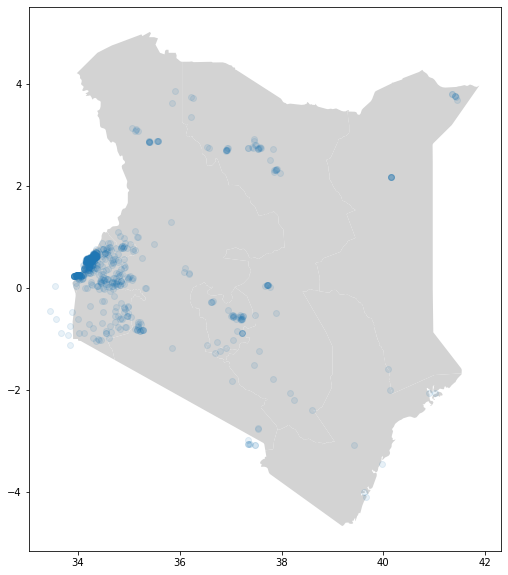

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
boundary["geometry"].to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
kenya_test.plot(ax=ax, alpha=0.1)

In [ ]:
ken_mask = kenya_test.within(bnd)
filtered = kenya_test.loc[ken_mask].copy()
filtered

,lat,lon,class_probability,ee_pts,test_class,country,harvest_togo,harvest_kenya,harvest_tanzania,geometry
0,0.725122,34.386282,0.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",0,Kenya,NaN,1.0,NaN,POINT (34.38628 0.72512)
1,0.621939,34.466496,0.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",0,Kenya,NaN,1.0,NaN,POINT (34.46650 0.62194)
3,0.226497,34.054859,0.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",0,Kenya,NaN,0.0,NaN,POINT (34.05486 0.22650)
4,0.096834,33.951959,0.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",0,Kenya,NaN,0.0,NaN,POINT (33.95196 0.09683)
5,0.032072,33.968469,0.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",0,Kenya,NaN,0.0,NaN,POINT (33.96847 0.03207)
...,...,...,...,...,...,...,...,...,...,...
824,0.633255,34.313450,1.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",1,Kenya,NaN,1.0,NaN,POINT (34.31345 0.63326)
825,0.630631,34.314150,1.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",1,Kenya,NaN,1.0,NaN,POINT (34.31415 0.63063)
826,0.625610,34.307610,1.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",1,Kenya,NaN,1.0,NaN,POINT (34.30761 0.62561)
827,0.694220,34.369890,1.0,"ee.Feature({\n ""functionInvocationValue"": {\n...",1,Kenya,NaN,1.0,NaN,POINT (34.36989 0.69422)


<AxesSubplot:>

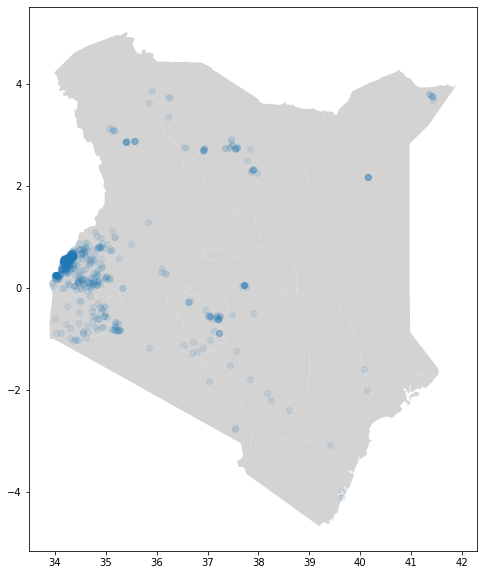

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
boundary.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
filtered.plot(ax=ax, alpha=0.1)

## **Section 2** - Copernicus, ESA, GLAD

**Copernicus Land Cover** ([Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#description))

In [56]:
# Load copernicus data
copernicus = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")
cop_results = copernicus.select("discrete_classification").filterDate("2019-01-01", "2020-01-01").map(lambda x: raster_extraction(x, 100, test_coll)).flatten()

In [57]:
cop_sampled = geemap.ee_to_gdf(cop_results)
cop_sampled["cop_class"] = cop_sampled["discrete_classification"].apply(lambda x: map_values(x, 40))
cop_sampled.head()

,geometry,class_probability,discrete_classification,lat,lon,cop_class
0,None,0.0,126,0.725122,34.386282,0
1,None,0.0,122,0.621939,34.466496,0
2,None,0.0,40,0.226497,34.054859,1
3,None,0.0,20,0.096834,33.951959,0
4,None,0.0,80,0.032072,33.968469,0


In [58]:
test_data["cop"] = pd.merge(test_data, cop_sampled, on=["lat", "lon"], how="left")["cop_class"]

**ESA World Cover** ([Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100)) 

In [59]:
esa = ee.ImageCollection("ESA/WorldCover/v100")
esa_results = esa.filterBounds(test_coll).map(lambda x: raster_extraction(x, 10, test_coll)).flatten()

In [60]:
esa_sampled = geemap.ee_to_gdf(esa_results)
esa_sampled["esa_class"] = esa_sampled["Map"].apply(lambda x: map_values(x, 40))
esa_sampled.head()

,geometry,Map,class_probability,lat,lon,esa_class
0,None,20,0.0,0.725122,34.386282,0
1,None,20,0.0,0.621939,34.466496,0
2,None,30,0.0,0.226497,34.054859,0
3,None,30,0.0,0.096834,33.951959,0
4,None,80,0.0,0.032072,33.968469,0


In [61]:
test_data["esa"] = pd.merge(test_data, esa_sampled, on=["lat", "lon"], how="left")["esa_class"]

**GLAD Global** ([Earth Engine](https://glad.earthengine.app/view/global-cropland-dynamics))

In [62]:
glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019")
glad_results = glad.filterBounds(test_coll).map(lambda x: raster_extraction(x, 30, test_coll)).flatten()

In [63]:
glad_sampled = geemap.ee_to_gdf(glad_results)
glad_sampled.head()

,geometry,b1,class_probability,lat,lon
0,None,1,0.0,0.725122,34.386282
1,None,0,0.0,0.621939,34.466496
2,None,0,0.0,0.226497,34.054859
3,None,0,0.0,0.096834,33.951959
4,None,0,0.0,0.032072,33.968469


In [64]:
test_data['glad'] = pd.merge(test_data, glad_sampled, on=["lat", "lon"], how="left")["b1"]

In [65]:
test_data.to_csv("../../intercomparison-data/extracted.csv")

## **Evaluation Results**

**Compute results**

In [71]:
for country, df in test_data.groupby("country"):
    for dataset in ["cop", "esa", "glad", "harvest_togo", "harvest_kenya", "harvest_tanzania"]:
        # If country is non-empty
        if not pd.isnull(df[dataset]).all():
            print(country + ": " + dataset)
            # Remove na values
            temp = df[["test_class", dataset]].dropna()
            if len(temp) > 10:
                report = classification_report(temp["test_class"], temp[dataset], output_dict= True)     

            results[country] = report_to_row(dataset, report, results[country])

Kenya: cop


c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyError: '1'

**Kenya**

In [ ]:
results["Kenya"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.913148,0.937824,571,258,0.925043,0.950963,0.884298,0.829457
0,esa,0.449940,0.341040,571,258,0.975207,0.206655,0.360169,0.988372
0,glad,0.849216,0.885636,571,258,0.927203,0.847636,0.716612,0.852713
0,harvest_kenya,0.952722,0.968054,520,178,0.974659,0.961538,0.891892,0.926966
0,harvest_tanzania,0.952722,0.968054,520,178,0.974659,0.961538,0.891892,0.926966


**Togo**

In [ ]:
results["Togo"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.732394,0.541063,107,248,0.560000,0.523364,0.800000,0.822581
0,esa,0.794366,0.613757,107,248,0.707317,0.542056,0.820513,0.903226
0,glad,0.783099,0.596859,107,248,0.678571,0.532710,0.815498,0.891129
0,harvest_togo,0.746479,0.656489,107,248,0.554839,0.803738,0.895000,0.721774


**Tanzania**

In [ ]:
results["Tanzania_CEO_2019"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,cop,0.811439,0.630513,629,2081,0.578249,0.693164,0.901329,0.847189
0,esa,0.840030,0.665610,629,2009,0.663507,0.667727,0.895761,0.893977
0,glad,0.836900,0.646400,629,2081,0.650564,0.642289,0.892293,0.895723
0,harvest_kenya,0.791277,0.562092,104,217,0.877551,0.413462,0.775735,0.972350
0,harvest_tanzania,0.784224,0.643703,431,1103,0.600402,0.693735,0.872587,0.819583
